# Импортируем необходимые библиотеки

In [ ]:
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install optuna
!pip install openfe
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 21.6 MB/s eta 0:00:00


In [ ]:
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
import lightgbm as lgb

import optuna

import warnings
warnings.filterwarnings('ignore')

# Загрузим данные

In [ ]:
train_features = pd.read_csv('train_features.csv', index_col='match_id_hash')
train_targets = pd.read_csv( 'train_targets.csv', index_col='match_id_hash')

In [ ]:
train_features.head(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_targets.head(2)

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN


In [ ]:
X = train_features

y = train_targets['radiant_win']
y = y.astype(int)

X.shape

(39675, 245)

# EDA (5 баллов)

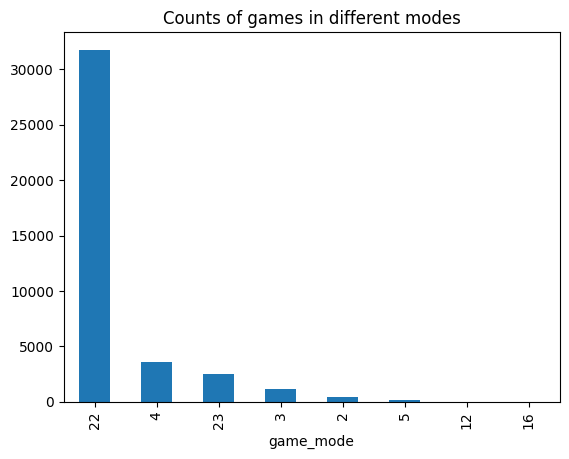

In [ ]:
# тут EDA, который вы считаете необходимым, например, изучим количество игр в разных режимах

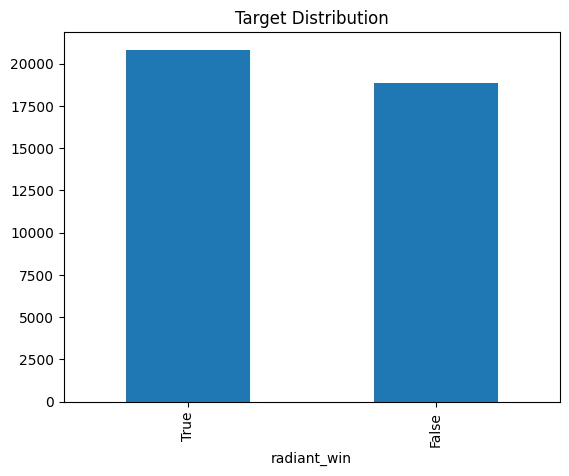

In [ ]:
# посмотрим распределение таргета

#У меня есть пару теорий относительно корреляции между победой и определенными фичами. Дота - в первую очередь про экономику
#Networth (или gold в датасете) игроков на 1,2,3 позициях - ключевой фактор каждой победы. Если говорить про 4 и 5, то можно
#анализировать их r_support и опсы с вардами ( в колличественном эквиваленте)

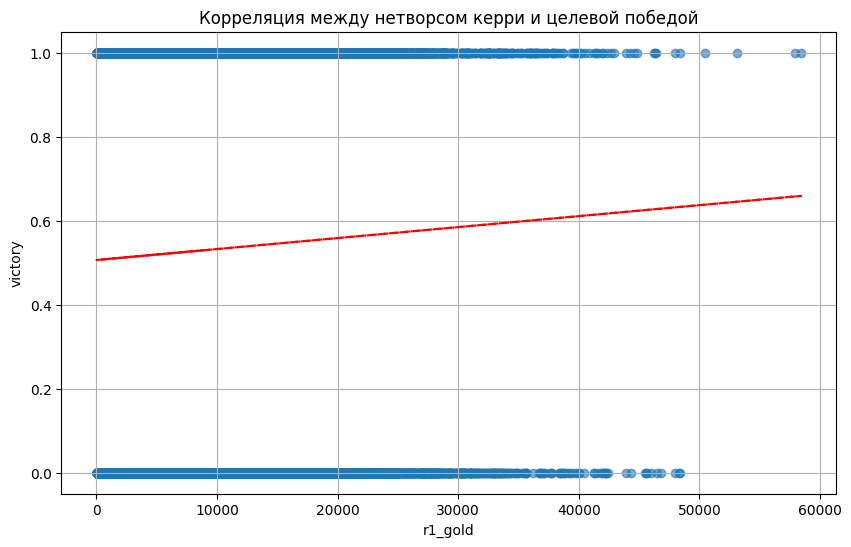

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

#X = X.loc[X['r1_gold'] < 10000] #уберем шума
#y = y.iloc[:X.shape[0]]

plt.figure(figsize=(10, 6))
plt.scatter(X['r1_gold'], y, alpha=0.6)
plt.title('Корреляция между нетворсом керри и целевой победой')
plt.xlabel('r1_gold')
plt.ylabel('victory')
plt.grid(True)


z = np.polyfit(X['r1_gold'], y, 1)
p = np.poly1d(z)
plt.plot(X['r1_gold'], p(X['r1_gold']), "r--")

plt.show()


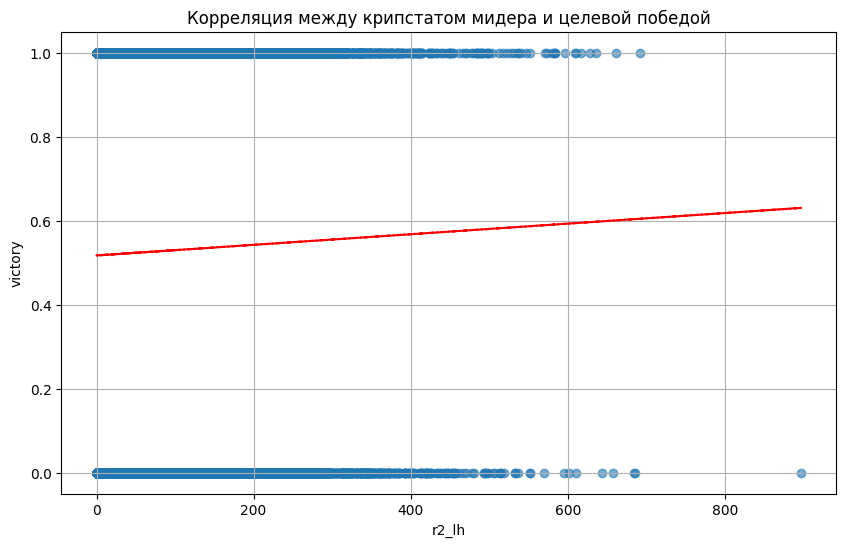

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10, 6))
plt.scatter(X['r2_lh'], y, alpha=0.6)
plt.title('Корреляция между крипстатом мидера и целевой победой')
plt.xlabel('r2_lh')
plt.ylabel('victory')
plt.grid(True)


z = np.polyfit(X['r2_lh'], y, 1)
p = np.poly1d(z)
plt.plot(X['r2_lh'], p(X['r2_lh']), "r--")

plt.show()

Интересно, но между участием керри и победой в драках нет зависимости

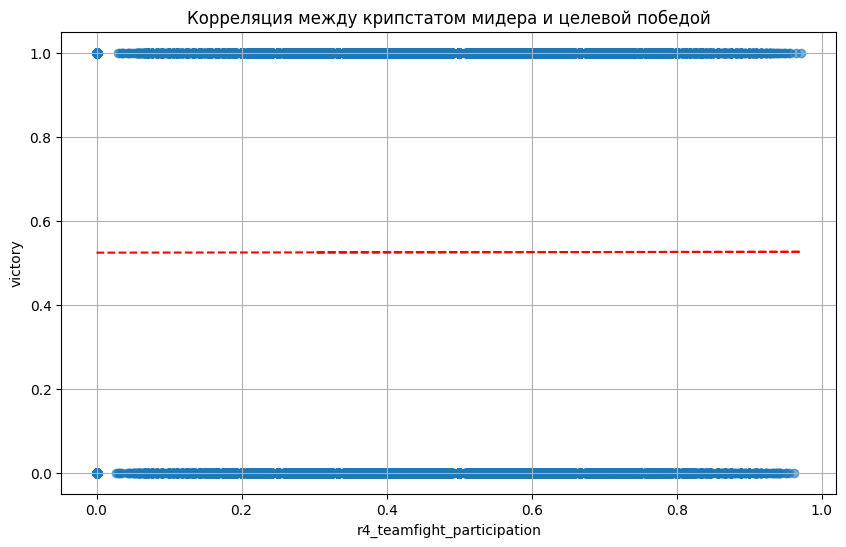

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


X = X.loc[X['r1_teamfight_participation'] < 1.00]
y = y.iloc[:X.shape[0]]

plt.figure(figsize=(10, 6))
plt.scatter(X['r1_teamfight_participation'], y, alpha=0.6)
plt.title('Корреляция между участием керри в драках и целевой победой')
plt.xlabel('r1_teamfight_participation')
plt.ylabel('victory')
plt.grid(True)


z = np.polyfit(X['r1_teamfight_participation'], y, 1)
p = np.poly1d(z)
plt.plot(X['r1_teamfight_participation'], p(X['r1_teamfight_participation']), "r--")

plt.show()

Также на гистограмме можно выразить обратную зависимость побед сил света и величины тех же метрик, что и сверху, но у вражеских героев


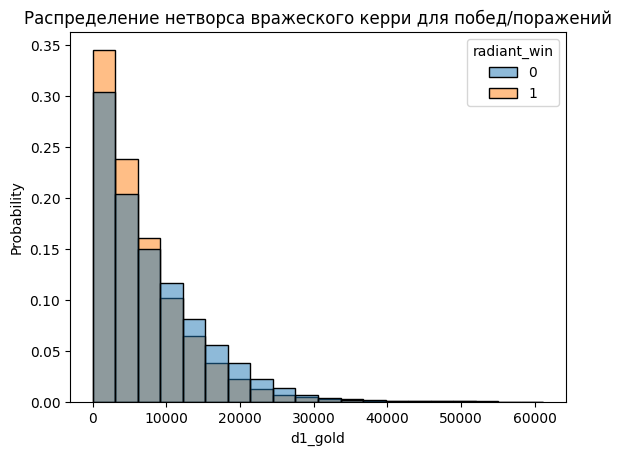

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.histplot(data=X, x=X['d1_gold'], hue=y,
             bins=20, stat='probability', common_norm=False, alpha=0.5)
plt.title('Распределение нетворса вражеского керри для побед/поражений')

plt.show()

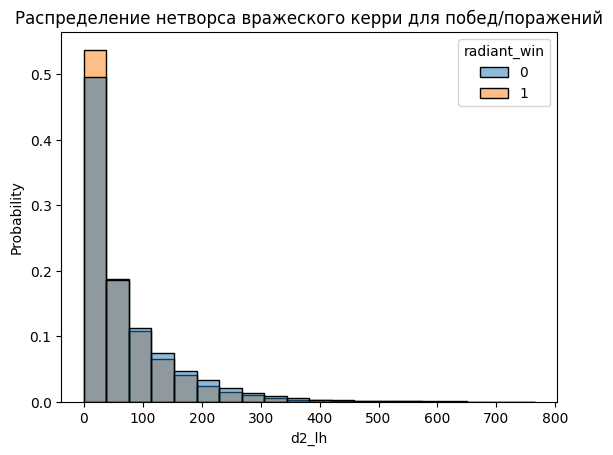

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.histplot(data=X, x=X['d2_lh'], hue=y,
             bins=20, stat='probability', common_norm=False, alpha=0.5)
plt.title('Распределение нетворса вражеского керри для побед/поражений')

plt.show()

Добавим теперь нормальный EDA
1. Гистограммы для анализа распределения фич
2. Боксплоты для анализа выбросов

<function matplotlib.pyplot.show(close=None, block=None)>

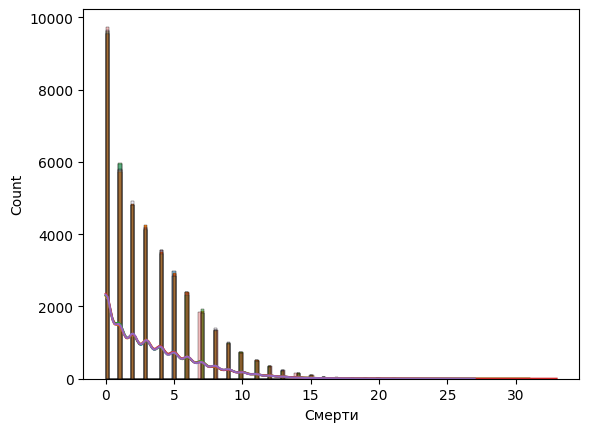

In [ ]:
import seaborn as sns
sns.histplot(data=X, x=X["r1_deaths"], kde=True)
sns.histplot(data=X, x=X["r2_deaths"], kde=True,alpha=0.9)
sns.histplot(data=X, x=X["r3_deaths"], kde=True,alpha=0.5)
sns.histplot(data=X, x=X["r4_deaths"], kde=True,alpha=0.3)
sns.histplot(data=X, x=X["r5_deaths"], kde=True,alpha=0.1)
plt.xlabel('Смерти')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

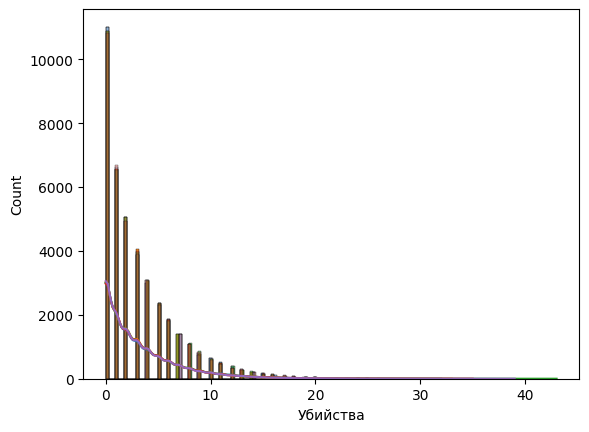

In [ ]:
import seaborn as sns
sns.histplot(data=X, x=X["r1_kills"], kde=True)
sns.histplot(data=X, x=X["r2_kills"], kde=True,alpha=0.9)
sns.histplot(data=X, x=X["r3_kills"], kde=True,alpha=0.5)
sns.histplot(data=X, x=X["r4_kills"], kde=True,alpha=0.3)
sns.histplot(data=X, x=X["r5_kills"], kde=True,alpha=0.1)
plt.xlabel('Убийства')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

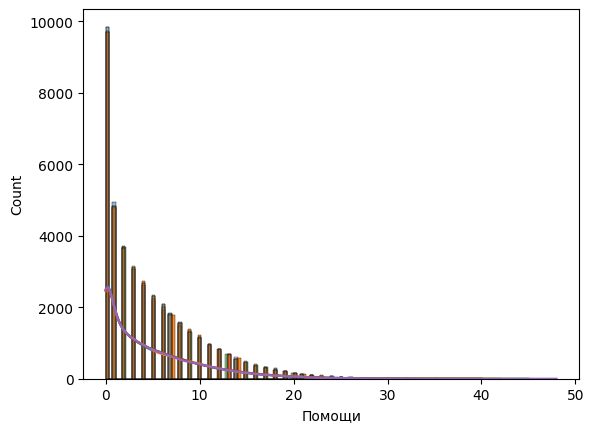

In [ ]:
import seaborn as sns
sns.histplot(data=X, x=X["r1_assists"], kde=True)
sns.histplot(data=X, x=X["r2_assists"], kde=True,alpha=0.9)
sns.histplot(data=X, x=X["r3_assists"], kde=True,alpha=0.5)
sns.histplot(data=X, x=X["r4_assists"], kde=True,alpha=0.3)
sns.histplot(data=X, x=X["r5_assists"], kde=True,alpha=0.1)
plt.xlabel('Помощи')
plt.show

чет мне совсем не нравится, что у всех позиций одинаковое распределение КДА

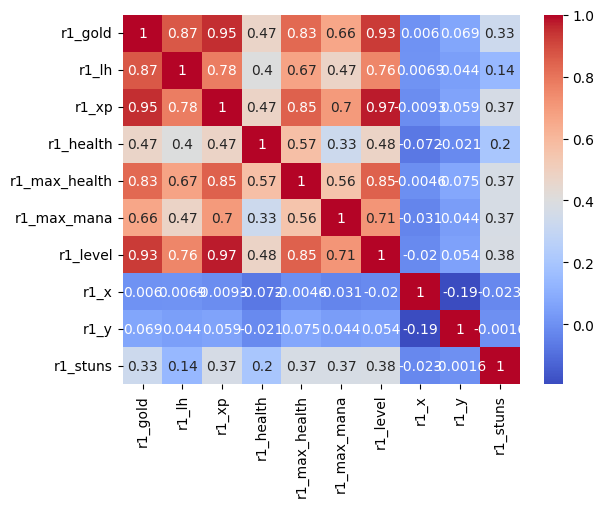

In [ ]:
X_c = X.iloc[:,10:20]
sns.heatmap(X_c.corr(), annot=True, cmap="coolwarm")
plt.show()

<Axes: xlabel='r1_kills', ylabel='r2_kills'>

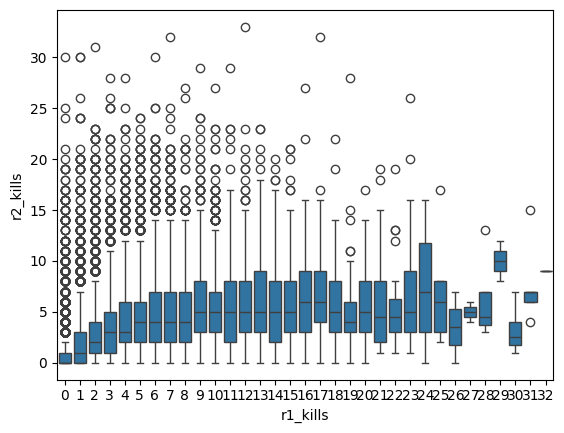

In [ ]:
sns.boxplot(data=X,x='r1_kills',y='r2_kills')

# Обучим CatBoost на чистых данных и посмотрим на метрики

In [ ]:
# Эту секцию я использую чтобы проверить свои теории относительно зависимости определенных фич с победами, ну и посмотрю скор начальный
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = CatBoostClassifier(
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')


feature_importance = model.get_feature_importance()
feature_names = model.feature_names_



importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:20],importance_df['Importance'][:20])
plt.show()

#в целом, исходя изнескольких графиков фич импортенса видно, что голда и смерти позиций появлятся достаточно часто, чаще чем участие в драках
#или кили или ассисты.
#на основнии этого будем фичеинженирить. Полагаю неплохо будет сначала завести по фиче для суммирвания всех статов на команду.


KeyboardInterrupt: 

# Генерация фичей (5 баллов)

Генерация фичей является одной из важнейших частей построения пайплайна машинного обучения. В данной части вам предлагается придумать и сгенерировать полезные фичи для модели. Важно: они должны повысить метрику. В качестве примера сгенерированы статистические фичи. Вы можете не использовать их, если не считаете их нужными.

In [ ]:
def fe(data):
    eps = 1e-8
    for c in [
        'kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp',
        'health', 'max_health', 'max_mana', 'level', 'x', 'y',
        'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
        'firstblood_claimed', 'teamfight_participation', 'towers_killed',
        'roshans_killed', 'obs_placed', 'sen_placed'
    ]:

        r_columns = [f'r{i}_{c}' for i in range(1, 6)]
        d_columns = [f'd{i}_{c}' for i in range(1, 6)]

        r_core_columns = [f'r{i}_{c}' for i in range(1,4)]
        d_core_columns = [f'd{i}_{c}' for i in range(1,4)]

        r_sup_columns = [f'r{i}_{c}' for i in range(4,6)]
        d_sup_columns = [f'd{i}_{c}' for i in range(4,6)]




        data['r_total_' + c] = data[r_columns].sum(1)
        data['d_total_' + c] = data[d_columns].sum(1)
        data['total_' + c + '_ratio'] = data['r_total_' + c] / (data['d_total_' + c] + eps)

        data['r_std_' + c] = data[r_columns].std(1)
        data['d_std_' + c] = data[d_columns].std(1)

        data['r_median_' + c] = data[r_columns].median(1)
        data['d_median_' + c] = data[d_columns].median(1)

        data['r_min_' + c] = data[r_columns].min(1)
        data['d_min_' + c] = data[d_columns].min(1)

        data['r_max_' + c] = data[r_columns].max(1)
        data['d_max_' + c] = data[d_columns].max(1)

        data['r_minmax_diff_'+ c] = data['r_max_' + c] - data['r_min_' + c]
        data['d_minmax_diff_'+ c] = data['d_max_' + c] - data['d_min_' + c]

        data['r_minmax_ratio_'+ c] = data['r_max_' + c] / (data['r_min_' + c] + eps)
        data['d_minmax_ratio_'+ c] = data['d_max_' + c] / (data['d_min_' + c] + eps)

        #вообще похорошему общий импакт от коров хорошо вынести в отдельную фичу
        data['r_core_avg_' + c] = data[r_core_columns].mean(1)
        data['r_core_sum_' + c] = data[r_core_columns].sum(1)
        data['d_core_avg_' + c] = data[d_core_columns].mean(1)
        data['d_core_sum_' + c] = data[d_core_columns].sum(1)

        # ну и от сапов тада почему нет лол
        data['r_sup_avg_' + c] = data[r_sup_columns].mean(1)
        data['r_sup_sum_' + c] = data[r_sup_columns].sum(1)
        data['d_sup_avg_' + c] = data[d_sup_columns].mean(1)
        data['d_sup_sum_' + c] = data[d_sup_columns].sum(1)


        data['r_sup_vs_core_' + c] = data['r_core_avg_' + c] - data['r_sup_avg_' + c]
        data['d_sup_vs_core_' + c] = data['d_core_avg_' + c] - data['d_sup_avg_' + c]


        #бинарные фичи доминирования
        data['r_dom_' + c] = (data['r_total_' + c] > data['d_total_' + c]).astype(int)
        data['d_dom_' + c] = (data['r_total_' + c] < data['d_total_' + c]).astype(int)

        data['r_core_dom_' + c] = (data['r_core_sum_' + c] > data['d_core_sum_' + c]).astype(int)
        data['d_core_dom_' + c] = (data['r_core_sum_' + c] < data['d_core_sum_' + c]).astype(int)


    for first in [
        'kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp',
        'health', 'max_health', 'max_mana', 'level', 'x', 'y',
        'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
        'firstblood_claimed', 'teamfight_participation', 'towers_killed',
        'roshans_killed', 'obs_placed', 'sen_placed'
    ]:
      r_columns_first = [f'r{i}_{first}' for i in range(1, 6)]
      d_columns_first = [f'd{i}_{first}' for i in range(1, 6)]

      r_core_columns_first = [f'r{i}_{first}' for i in range(1,4)]
      d_core_columns_first = [f'd{i}_{first}' for i in range(1,4)]

      r_sup_columns_first = [f'r{i}_{first}' for i in range(4,6)]
      d_sup_columns_first = [f'd{i}_{first}' for i in range(4,6)]
      for second in [
        'kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp',
        'health', 'max_health', 'max_mana', 'level', 'x', 'y',
        'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
        'firstblood_claimed', 'teamfight_participation', 'towers_killed',
        'roshans_killed', 'obs_placed', 'sen_placed'
    ]:
        r_columns_second = [f'r{i}_{second}' for i in range(1, 6)]
        d_columns_second = [f'd{i}_{second}' for i in range(1, 6)]

        r_core_columns_second = [f'r{i}_{second}' for i in range(1,4)]
        d_core_columns_second = [f'd{i}_{second}' for i in range(1,4)]

        r_sup_columns_second = [f'r{i}_{second}' for i in range(4,6)]
        d_sup_columns_second = [f'd{i}_{second}' for i in range(4,6)]
        if first!=second:
          data['r_' + first+'_+_'+second] = data[r_columns_first].sum(1) + data[r_columns_second].sum(1)
          data['r_' + first+'_-_'+second] = data[r_columns_first].sum(1) - data[r_columns_second].sum(1)
          data['r_' + first+'_*_'+second] = data[r_columns_first].sum(1) * data[r_columns_second].sum(1)
          data['r_' + first+'_/_'+second] = data[r_columns_first].sum(1) / (data[r_columns_second].sum(1) + eps)

          data['d_' + first+'_+_'+second] = data[d_columns_first].sum(1) + data[d_columns_second].sum(1)
          data['d_' + first+'_-_'+second] = data[d_columns_first].sum(1) - data[d_columns_second].sum(1)
          data['d_' + first+'_*_'+second] = data[d_columns_first].sum(1) * data[d_columns_second].sum(1)
          data['d_' + first+'_/_'+second] = data[d_columns_first].sum(1) / (data[d_columns_second].sum(1) + eps)

          data['r_core_' + first+'_+_'+second] = data[r_core_columns_first].sum(1) + data[r_core_columns_second].sum(1)
          data['r_core_' + first+'_-_'+second] = data[r_core_columns_first].sum(1) - data[r_core_columns_second].sum(1)
          data['r_core_' + first+'_*_'+second] = data[r_core_columns_first].sum(1) * data[r_core_columns_second].sum(1)
          data['r_core_' + first+'_/_'+second] = data[r_core_columns_first].sum(1) / (data[r_core_columns_second].sum(1) + eps)

          data['d_core_' + first+'_+_'+second] = data[d_core_columns_first].sum(1) + data[d_core_columns_second].sum(1)
          data['d_core_' + first+'_-_'+second] = data[d_core_columns_first].sum(1) - data[d_core_columns_second].sum(1)
          data['d_core_' + first+'_*_'+second] = data[d_core_columns_first].sum(1) * data[d_core_columns_second].sum(1)
          data['d_core_' + first+'_/_'+second] = data[d_core_columns_first].sum(1) / (data[d_core_columns_second].sum(1) + eps)

          data['r_sup_' + first+'_+_'+second] = data[r_sup_columns_first].sum(1) + data[r_sup_columns_second].sum(1)
          data['r_sup_' + first+'_-_'+second] = data[r_sup_columns_first].sum(1) - data[r_sup_columns_second].sum(1)
          data['r_sup_' + first+'_*_'+second] = data[r_sup_columns_first].sum(1) * data[r_sup_columns_second].sum(1)
          data['r_sup_' + first+'_/_'+second] = data[r_sup_columns_first].sum(1) / (data[r_sup_columns_second].sum(1) + eps)

          data['d_sup_' + first+'_+_'+second] = data[d_sup_columns_first].sum(1) + data[d_sup_columns_second].sum(1)
          data['d_sup_' + first+'_-_'+second] = data[d_sup_columns_first].sum(1) - data[d_sup_columns_second].sum(1)
          data['d_sup_' + first+'_*_'+second] = data[d_sup_columns_first].sum(1) * data[d_sup_columns_second].sum(1)
          data['d_sup_' + first+'_/_'+second] = data[d_sup_columns_first].sum(1) / (data[d_sup_columns_second].sum(1) + eps)


    return data

# Теперь обучим CatBoost на данных с новыми фичами и посмотрим на метрики

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train)
    X_valid = fe(X_valid)

    model = CatBoostClassifier(
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')


feature_importance = model.get_feature_importance()
feature_names = model.feature_names_



importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:20],importance_df['Importance'][:20])
plt.show()

# ну из всех нагенеренных фичей куча мусорных, отберем

KeyboardInterrupt: 

# Обработка категориальных фичей средствами CatBoost

Попробуем подать категориальные фичи в модель через cat_features.

In [ ]:
# выделим очевидные категориальные фичи - вы можете попробовать выделить больше / сгенерировать новые или же вовсе отказаться от этой идеи
cats = ['game_mode', 'lobby_type']

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train)
    X_valid = fe(X_valid)

    model = CatBoostClassifier(
        cat_features=cats,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT w/ FE OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8361, Accuracy score: 0.7471
FOLD 1, Validation ROC-AUC score: 0.8162, Accuracy score: 0.7260


KeyboardInterrupt: 

# Отбор фичей (5 баллов)

Возможно, на этапе генерации фичей вы решили прибегнуть к автоматической генерации (если нет, то советую обратить внимание на библиотеку OpenFE), или же просто генерировали все подряд. Также, возможно, исходные данные содержали бесполезные и шумные фичи.

Вам предлагается исследовать это и оставить только те фичи, которые вы считаете важными.

Идеи для отбора фичей:
- по feature importance
- по permutation importance
- по shap values
- recursive feature elimination
- sequential feature selection

Также обратите внимание на гайд от catboost: https://github.com/catboost/catboost/blob/master/catboost/tutorials/feature_selection/select_features_tutorial.ipynb

In [ ]:
CatBoostClassifier.select_features??

In [ ]:
# бейзлайн: используем встроенные инструменты catboost - вы можете работать с ним или обратиться к другим инструментам
# здесь нужно быть аккуратным, ведь удаление фичей всегда может привести к падению скора
# необходимо подобрать грамотный подход, а это можно сделать только путем экспериментов

model = CatBoostClassifier(
    cat_features=cats,
    random_state=69,
    verbose=0,
    thread_count=4
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

X_train = fe(X_train)
X_test = fe(X_test)

train_pool = Pool(X_train, y_train, cat_features=cats)
test_pool = Pool(X_test, y_test, cat_features=cats)

summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select=list(range(X_train.shape[1])),
    num_features_to_select=200, #200 показывает оптимальный скор
    algorithm='Sequential',# я выбираю последовтельное потому что у меня и так модель час обучается господи
    steps=10, # количество шагов я выбрал 10 тоже для ускорения
    shap_calc_type='Approximate', # я понимаю, что могу потерять точность, но ждать сутки я не намерен
    train_final_model=False,
    verbose=None,
    logging_level=None,
    plot=False
)

selected_features = summary['selected_features'] # отобранные фичи

Learning rate set to 0.073263
Step #1 out of 1


KeyboardInterrupt: 

# Обучим модель на отобранных и фичах и посмотрим на метрики

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    model = CatBoostClassifier(
        cat_features=cats,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8395, Accuracy score: 0.7480
FOLD 1, Validation ROC-AUC score: 0.8198, Accuracy score: 0.7312
FOLD 2, Validation ROC-AUC score: 0.8239, Accuracy score: 0.7347
FOLD 3, Validation ROC-AUC score: 0.8230, Accuracy score: 0.7360
FOLD 4, Validation ROC-AUC score: 0.8263, Accuracy score: 0.7372

Overall CAT w/ FE&FS OOF ROC-AUC: 0.8264, OOF Accuracy: 0.7374


In [ ]:
from sklearn.inspection import permutation_importance
import shap
from collections import Counter
#тут попробую свой отбор написать и сравнить с бейзлайном ^
#сделаю голосование


model = CatBoostClassifier(
    cat_features=cats,
    random_state=69,
    verbose=0,
    thread_count=4,
    iterations=500
)
model.fit(X_train,y_train)

#feature importance

imp = model.get_feature_importance()
top_200_fi = X_train.colums[imp.agrsort()[-200:][::-1]]

#permutation importance
permutation_importance(model,X_train,y_train,n_repeats = 5,random_state = 69)
top_200_pi = X_train.colums[permutation_importance.agrsort()[-200:][::-1]]

#shap
shaps = shap.TreeExplainer(model)
shap_v = shaps.shap_values(X_train)
shap_imp = np.abs(shap_v).mean(axis=0)
top_200_s = X_train.colums[shap_imp.agrsort()[-200:][::-1]]


#голосование КАСТ ЕР ВОЙТ НИГГА
all_feats = list(top_200_fi) + list(top_200_pi) + list(top_200_s) + list(selected_features)
GOLOSOVANIE = Counter(all_feats)
GOLOSOVANIE_final = [feat for feat,count in GOLOSOVANIE.items() if count >= 2]




In [ ]:
#ну теперь посмотрим что получилось

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    X_train = fe(X_train).iloc[:, GOLOSOVANIE_final]
    X_valid = fe(X_valid).iloc[:, GOLOSOVANIE_final]

    model = CatBoostClassifier(
        cat_features=cats,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

# Блендинг: добавим XGBoost и LightGBM

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_lgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # lgbm требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    model = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=69,
        n_jobs=4,
        metric='auc',
        early_stopping_round=100,
        verbosity=-1
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        categorical_feature=cats
    )

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_lgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_lgb)
oof_accuracy = accuracy_score(y, oof_lgb > 0.5)
print(f'\nOverall LGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8397, Accuracy score: 0.7472
FOLD 1, Validation ROC-AUC score: 0.8204, Accuracy score: 0.7332
FOLD 2, Validation ROC-AUC score: 0.8215, Accuracy score: 0.7302
FOLD 3, Validation ROC-AUC score: 0.8216, Accuracy score: 0.7330
FOLD 4, Validation ROC-AUC score: 0.8263, Accuracy score: 0.7384

Overall LGB w/ FE&FS OOF ROC-AUC: 0.8258, OOF Accuracy: 0.7364


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_xgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # xgb требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    cat_columns = [X_train.columns.get_loc(col) for col in cats]

    model = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=69,
        n_jobs=4,
        eval_metric='auc',
        early_stopping_rounds=100,
        use_label_encoder=False,
        enable_categorical=True,
        tree_method='hist'
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_xgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_xgb)
oof_accuracy = accuracy_score(y, oof_xgb > 0.5)
print(f'\nOverall XGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8373, Accuracy score: 0.7481
FOLD 1, Validation ROC-AUC score: 0.8197, Accuracy score: 0.7312
FOLD 2, Validation ROC-AUC score: 0.8220, Accuracy score: 0.7313
FOLD 3, Validation ROC-AUC score: 0.8215, Accuracy score: 0.7308
FOLD 4, Validation ROC-AUC score: 0.8264, Accuracy score: 0.7391

Overall XGB w/ FE&FS OOF ROC-AUC: 0.8252, OOF Accuracy: 0.7361


In [ ]:
# сблендим предсказания и посмотрим на метрики

oof_blend = (oof_cat + oof_lgb + oof_xgb) / 3

oof_roc_auc = roc_auc_score(y, oof_blend)
oof_accuracy = accuracy_score(y, oof_blend > 0.5)
print(f'\nOverall BLEND w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')


Overall BLEND w/ FE&FS OOF ROC-AUC: 0.8274, OOF Accuracy: 0.7378


# Подбор гиперпараметров (15 баллов)

Для изучения того, какие гиперпараметры доступны у модели для выбора можно использовать '? ModelName'
Определитесь с тем, какие гиперпараметры вы хотите оптимизировать и укажите их в objective. Выполните поиск гиперпараметров с Optuna

In [ ]:
# ? CatBoostClassifier

In [ ]:
# ? lgb.LGBMClassifier

In [ ]:
# ? XGBClassifier

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'depth': trial.suggest_int('depth', 2, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 20),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS'])
    }

    if 'cats' in globals():
        params['cat_features'] = cats

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_cat = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]

        model = CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            early_stopping_rounds=100,
            verbose=0
        )

        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_cat[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_cat)

    return oof_roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

cat_params = study.best_params
cat_params

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        "boosting_type": trial.suggest_categorical("lgb_boosting_type", ["gbdt", "dart", "goss", "rf"]),
        "num_leaves": trial.suggest_int("lgb_num_leaves", 20, 512),
        "max_depth": trial.suggest_int("lgb_max_depth", -1, 20),  # -1 means no limit
        "learning_rate": trial.suggest_loguniform("lgb_learning_rate", 1e-5, 0.3),
        "n_estimators": trial.suggest_int("lgb_n_estimators", 100, 2000, step=100),
        "min_child_samples": trial.suggest_int("lgb_min_child_samples", 5, 100),
        "min_child_weight": trial.suggest_loguniform("lgb_min_child_weight", 1e-5, 10.0),
        "subsample": trial.suggest_float("lgb_subsample", 0.4, 1.0),
        "subsample_freq": trial.suggest_int("lgb_subsample_freq", 0, 10),
        "colsample_bytree": trial.suggest_float("lgb_colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_loguniform("lgb_reg_alpha", 1e-8, 10.0),  # L1 regularization
        "reg_lambda": trial.suggest_loguniform("lgb_reg_lambda", 1e-8, 10.0),  # L2 regularization
        "scale_pos_weight": trial.suggest_float("lgb_scale_pos_weight", 1.0, 10.0),
        "min_split_gain": trial.suggest_float("lgb_min_split_gain", 0.0, 1.0),
        "drop_rate": trial.suggest_float("lgb_drop_rate", 0.0, 1.0),  # для dart
        "max_bin": trial.suggest_int("lgb_max_bin", 100, 512),
        "bagging_fraction": trial.suggest_float("lgb_bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("lgb_bagging_freq", 0, 10),
        "verbose": -1,
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_lgb = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]

        for col in cats:
            X_train[col] = X_train[col].astype('category')
            X_valid[col] = X_valid[col].astype('category')

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            categorical_feature=cats,
        )

        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_lgb[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_lgb)

    return oof_roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

lgb_params = study.best_params
lgb_params

In [ ]:
def objective(trial):
    params = {
       "depth": trial.suggest_int("cat_depth", 4, 16),
       "learning_rate": trial.suggest_loguniform("cat_learning_rate", 1e-5, 0.5),
       "iterations": trial.suggest_int("cat_iterations", 100, 2000, step=100),
       "l2_leaf_reg": trial.suggest_float("cat_l2_leaf_reg", 1, 10),
       "bagging_temperature": trial.suggest_float("cat_bagging_temperature", 0.0, 1.0),
       "random_strength": trial.suggest_float("cat_random_strength", 1e-3, 20.0),
       "border_count": trial.suggest_int("cat_border_count", 32, 255),
       "ctr_border_count": trial.suggest_int("cat_ctr_border_count", 50, 200),
       "max_ctr_complexity": trial.suggest_int("cat_max_ctr_complexity", 1, 4),
       "one_hot_max_size": trial.suggest_int("cat_one_hot_max_size", 2, 10),
       "rsm": trial.suggest_float("cat_rsm", 0.1, 1.0),
       "scale_pos_weight": trial.suggest_float("cat_scale_pos_weight", 1.0, 10.0),
       "od_type": trial.suggest_categorical("cat_od_type", ["IncToDec", "Iter", "None"]),
       "od_wait": trial.suggest_int("cat_od_wait", 10, 100),
       "boosting_type": trial.suggest_categorical("cat_boosting_type", ["Plain", "Ordered"]),
       "task_type": trial.suggest_categorical("cat_task_type", ["CPU", "GPU"]),
       "verbose": False,
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_xgb = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]


        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]

        for col in cats:
            X_train[col] = X_train[col].astype('category')
            X_valid[col] = X_valid[col].astype('category')

        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )

        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_xgb[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_xgb)

    return oof_roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

xgb_params = study.best_params

# Обучим модели с новыми гиперпараметрами

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    cat = CatBoostClassifier(
        **cat_params,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    cat.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = cat.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall Tuned CAT w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_lgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # lgbm требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    final_params = {
        **best_params,
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'random_state': 69,
        'n_jobs': 4,
        'verbosity': -1,
        'early_stopping_round': 100
    }

    lgb = lgb.LGBMClassifier(**final_params)
    lgb.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        categorical_feature=cats
    )

    y_pred = lgb.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_lgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_lgb)
oof_accuracy = accuracy_score(y, oof_lgb > 0.5)
print(f'\nOverall Tuned LGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_xgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # xgb требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    cat_columns = [X_train.columns.get_loc(col) for col in cats]

    final_params = {
        **xgb_params,
        'eval_metric': 'auc',
        'early_stopping_rounds': 100,
        'use_label_encoder': False,
        'enable_categorical': True,
        'tree_method': 'hist',
        'random_state': 69,
        'n_jobs': 4
    }

    xgb = XGBClassifier(**final_params)
    xgb.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    y_pred = xgb.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_xgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_xgb)
oof_accuracy = accuracy_score(y, oof_xgb > 0.5)
print(f'\nOverall Tuned XGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

In [ ]:
# сблендим предсказания и посмотрим на метрики

oof_blend = (oof_cat + oof_lgb + oof_xgb) / 3

oof_roc_auc = roc_auc_score(y, oof_blend)
oof_accuracy = accuracy_score(y, oof_blend > 0.5)
print(f'\nOverall Tuned BLEND w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

# Итоговая важность фичей

In [ ]:
feature_importance_cat = cat.get_feature_importance()
feature_names_cat = cat.feature_names_



importance_df = pd.DataFrame({
    'Feature': feature_names_cat,
    'Importance': feature_importance_cat
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:20],importance_df['Importance'][:20])
plt.show()


In [ ]:
feature_importance_xgb = xgb.get_feature_importance()
feature_names_xgb = xgb.feature_names_



importance_df = pd.DataFrame({
    'Feature': feature_names_xgb,
    'Importance': feature_importance_xgb
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:20],importance_df['Importance'][:20])
plt.show()

In [ ]:
feature_importance_lgb = lgb.get_feature_importance()
feature_names_lgb = lgb.feature_names_



importance_df = pd.DataFrame({
    'Feature': feature_names_lgb,
    'Importance': feature_importance_lgb
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:20],importance_df['Importance'][:20])
plt.show()